## 1) Check QML Transpiler

In [1]:
import qiskit

from qiskit.providers.aer import AerSimulator

from qiskit.providers.fake_provider import FakeBackend5QV2
from qiskit.providers.fake_provider import FakeLimaV2
from qiskit.providers.fake_provider import FakeMontrealV2
from qiskit.providers.fake_provider import FakeGuadalupeV2
from qiskit.providers.fake_provider import FakeBoeblingenV2

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from matplotlib import pyplot as plt

plt.style.use("dark_background")

%cd ..

from qml_transpiler import transpile
from qml_transpiler import transpile_left
from qml_transpiler import transpile_right
from qml_transpiler import transpile_chain

from qml_transpiler import get_full_map

from qml_transpiler import get_litmus_circuit
from qml_transpiler import get_cnot_circuit
from qml_transpiler import get_sinusoids

# %run ../latest/backend.ipynb
# %run ../latest/stacks.ipynb

/mnt/c/Users/mohor/Jupyter/Haiqu/transpiler


In [2]:
# Backend

FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
# FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

# backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Transpile Function

In [3]:
QUBITS_COUNT = 3

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

transpiled_litmus_circuit = transpile(
    litmus_circuit, 
    backend,
    # optimization_level=3,
    # initial_layout=[1, 2, 3],
    seed_transpiler=1234,
)

display(transpiled_litmus_circuit.draw(fold=-1))

print("full_map:", get_full_map(transpiled_litmus_circuit))

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                    
 ancilla_0 -> 0 ────────────────────────────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
                └─────────────────┘└───┘                          ░ 
 ancilla_1 -> 4 ────────────────────────────────────────────────────

full_map: [1, 3, 2, 0, 4]


### Transpile Right

#### Right Shoelace

In [4]:
QUBITS_COUNT = 4

# Circuits

initial_state_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)

initial_state_circuit.x(0)
initial_state_circuit.barrier()

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

# Transpile

transpiled_initial_state_circuit = transpile(
    initial_state_circuit,
    backend,
    seed_transpiler=1234,
    optimization_level=3
)

# transpiled_initial_state_circuit.draw(fold=-1)

shoelace_circuit = transpile_right(
    central_circuit=transpiled_initial_state_circuit,
    right_circuit=litmus_circuit,
    backend=backend,
    seed_transpiler=1234,
    optimization_level=3
)

display(shoelace_circuit.draw(fold=-1))

print("full_map:", get_full_map(transpiled_litmus_circuit))

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2 - 0.5*Litmus_3
                            ░ ┌─────────────────┐┌───┐                                         ░ 
      q_1 -> 0 ─────────────░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■───────────────────────░─
               ┌──────────┐ ░ ├─────────────────┤└─┬─┘┌───┐     ┌───┐┌─┴─┐                     ░ 
      q_0 -> 1 ┤ U(π,0,π) ├─░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├────────────■────────░─
               └──────────┘ ░ ├─────────────────┤     └─┬─┘┌─┴─┐└─┬─┘├───┤     ┌───┐┌─┴─┐      ░ 
      q_2 -> 2 ─────────────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                            ░ ├─────────────────┤          └───┘     └─┬─┘┌─┴─┐└─┬─┘└───┘┌─┴─┐ ░ 
      q_3 -> 3 ─────────────░─┤ U(0,0,Litmus_3) ├──────────────────────■──┤ X ├──■───────┤ X ├─░─
                            ░ └─────────────────┘                         └───┘          └───┘ ░ 
ancilla_0 -> 4 ────────────────────────────────────────────────────────────────────────────────░─
                                                                                               ░

full_map: [1, 3, 2, 0, 4]


#### Right CNOT 

In [5]:
QUBITS_COUNT = 3

# Circuits

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "CNOT")

# display(cnot_circuit.draw(fold=-1))

# Transpile

transpiled_litmus_circuit = qiskit.transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
)

# display(transpiled_litmus_circuit.draw(fold=-1))

right_cnot_circuit = transpile_right(
    central_circuit=transpiled_litmus_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

# display(right_cnot_circuit.draw(fold=-1))

right_cnot_circuit_2 = transpile_right(
    central_circuit=right_cnot_circuit,
    right_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

display(right_cnot_circuit_2.draw(fold=-1))

print("full_map:", get_full_map(right_cnot_circuit_2))

global phase: -1.0*CNOT_0 - 1.0*CNOT_1 - 1.0*CNOT_2 - 0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2
                                                                                                          ░                             
 ancilla_0 -> 0 ──────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────
                ┌─────────────────┐          ┌───┐          ┌───┐ ░ ┌───────────────┐                     ░ ┌───────────────┐      CNOT 
Litmus_0_2 -> 1 ┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─┤ U(0,0,CNOT_0) ├─────────────────■───░─┤ U(0,0,CNOT_0) ├──■────░───
                ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ ├───────────────┤┌───┐     ┌───┐┌─┴─┐ ░ ├───────────────┤┌─┴─┐  ░   
Litmus_0_0 -> 2 ┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─┤ U(0,0,CNOT_2) ├┤ X ├──■──┤ X ├┤ X ├─░─┤ U(0,0,CNOT_1) ├┤ X ├──░───
                ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ ├───────────────┤└─┬─┘┌─┴─┐└─┬─┘└───┘ ░ ├───────────────┤└───┘  ░   
Litmus_0_1 -> 3 ┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─┤ U(0,0,CNOT_1) ├──■──┤ X ├──■────────░─┤ U(0,0,CNOT_2) ├───────░───
                └─────────────────┘└───┘                          ░ └───────────────┘     └───┘           ░ └───────────────┘       ░   
 ancilla_1 -> 4 ──────────────────────────────────────────────────────────────────────────────────────────░─────────────────────────────
                                                                                                          ░

full_map: [3, 1, 2, 0, 4]


### Transpile Left

#### Left CNOT

In [6]:
QUBITS_COUNT = 3

# Circuits

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

cnot_circuit = get_cnot_circuit(QUBITS_COUNT, "cnot", [1, 2])

# display(cnot_circuit.draw(fold=-1))

# Transpile

transpiled_litmus_circuit = qiskit.transpile(
    litmus_circuit, 
    backend,
    seed_transpiler=1234,
)

# display(transpiled_litmus_circuit.draw(fold=-1))

left_cnot_circuit = transpile_left(
    central_circuit=transpiled_litmus_circuit,
    left_circuit=cnot_circuit,
    backend=backend,
    seed_transpiler=1234
)

left_cnot_circuit.draw(fold=-1)

global phase: -0.5*Litmus_0 - 0.5*Litmus_1 - 0.5*Litmus_2 - 0.5*cnot_0 - 0.5*cnot_1 - 0.5*cnot_2
                                                                                                                                    
ancilla_0 -> 0 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                              ┌───┐                           ░ ┌─────────────────┐          ┌───┐          ┌───┐ ░ 
 cnot_0_0 -> 1 ────────────────────────────■──┤ X ├──■────────────────────────░─┤ U(0,0,Litmus_2) ├───────■──┤ X ├──■───────┤ X ├─░─
               ┌───────────────────┐┌───┐┌─┴─┐└─┬─┘┌─┴─┐┌───────────────────┐ ░ ├─────────────────┤     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
 cnot_0_2 -> 2 ┤ U(0,1.0*cnot_2,0) ├┤ X ├┤ X ├──■──┤ X ├┤ U(0,1.0*cnot_0,0) ├─░─┤ U(0,0,Litmus_0) ├──■──┤ X ├──■──┤ X ├┤ X ├──■───░─
               ├───────────────────┤└─┬─┘└───┘     └───┘└───────────────────┘ ░ ├─────────────────┤┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
 cnot_0_1 -> 3 ┤ U(0,1.0*cnot_1,0) ├──■───────────────────────────────────────░─┤ U(0,0,Litmus_1) ├┤ X ├─────────────────■────────░─
               └───────────────────┘                                          ░ └─────────────────┘└───┘                          ░ 
ancilla_1 -> 4 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [7]:
get_full_map(left_cnot_circuit)

# [1, 3, 2, 0, 4]

[1, 3, 2, 0, 4]

### Stacks

In [8]:
QUBITS_COUNT = 3

QSEARCH_BLOCK_SIZE = 2

litmus_circuit = get_litmus_circuit(QUBITS_COUNT, "Litmus")

for index, parameter in enumerate(litmus_circuit.parameters):
    litmus_circuit.assign_parameters({parameter: index}, inplace=True)
    
STACKS = [
    "qiskit",
    # "qiskit_qsearch",
    # "qiskit_qfactor_qsearch",
    # "qiskit_pytket"
]

for stack in STACKS:
    
    print("stack:", stack)
    
    transpiled_litmus_circuit = transpile(
        litmus_circuit,
        backend,
        stack=stack,
        optimization_level=3,
        qsearch_block_size=QSEARCH_BLOCK_SIZE,
        seed_transpiler=1234)
    
    # transpiled_litmus_circuit = pass_manager.run(litmus_circuit)
    
    display("transpiled_litmus_circuit:", transpiled_litmus_circuit.draw(fold=-1))    

stack: qiskit


'transpiled_litmus_circuit:'

global phase: 4.7832
                                                             
 ancilla_0 -> 0 ─────────────────────────────────────────────
                ┌──────────┐          ┌───┐          ┌───┐ ░ 
Litmus_0_2 -> 1 ┤ U(0,0,2) ├───────■──┤ X ├──■───────┤ X ├─░─
                └──────────┘     ┌─┴─┐└─┬─┘┌─┴─┐┌───┐└─┬─┘ ░ 
Litmus_0_0 -> 2 ──────────────■──┤ X ├──■──┤ X ├┤ X ├──■───░─
                ┌──────────┐┌─┴─┐└───┘     └───┘└─┬─┘      ░ 
Litmus_0_1 -> 3 ┤ U(0,0,1) ├┤ X ├─────────────────■────────░─
                └──────────┘└───┘                          ░ 
 ancilla_1 -> 4 ─────────────────────────────────────────────

## 2) Check Transpilation Types

### Build Circuit Functions

In [9]:
def build_combined_circuit(circuit_parts, backend, *arguments, **key_arguments):
    
    qubits_count = circuit_parts[0].num_qubits

    # Compose

    combined_circuit = qiskit.QuantumCircuit(qubits_count)
    
    for circuit_part in circuit_parts:

        combined_circuit.compose(circuit_part, inplace=True)

    # combined_litmus_circuit.measure_active()

    # Transpile

    transpiled_combined_circuit = transpile(
        combined_circuit, 
        backend,
        *arguments, **key_arguments
    )
        
    return transpiled_combined_circuit

In [10]:
def build_blocks_circuit(circuit_parts, backend, *arguments, **key_arguments):
    
    # Transpile
    
    transpiled_circuit_parts = []
    
    for circuit_part in circuit_parts:
        
        transpiled_circuit_part = transpile(
            circuit_part,
            backend,
            *arguments, **key_arguments
        )
        
        transpiled_circuit_parts.append(transpiled_circuit_part)

        full_map = get_full_map(transpiled_circuit_part)
        
        initial_layout = full_map[:circuit_part.num_qubits]
        
        key_arguments['initial_layout'] = initial_layout

    # Compose
        
    blocks_circuit = None
    
    for transpiled_circuit_part in transpiled_circuit_parts:
        
        if blocks_circuit is None:
            blocks_circuit = transpiled_circuit_part
            
        else:      
            blocks_circuit.compose(transpiled_circuit_part, inplace=True)
        
    return blocks_circuit

In [11]:
def build_right_circuit(circuit_parts, backend, *arguments, **key_arguments):
    
    # Transpile
    
    central_circuit = transpile(
        circuit_parts[0],
        backend, 
        *arguments, **key_arguments
    )
    
    for right_circuit in circuit_parts[1:]:
        
        transpiled_right_circuit = transpile_right(
            central_circuit=central_circuit,
            right_circuit=right_circuit,
            backend=backend,
            *arguments, **key_arguments
        )
        
        central_circuit = transpiled_right_circuit
        
    return transpiled_right_circuit

In [12]:
def build_left_circuit(circuit_parts, backend, *arguments, **key_arguments):
    
    reversed_circuit_parts = list(reversed(circuit_parts))
    
    # Transpile
    
    central_circuit = transpile(
        reversed_circuit_parts[0],
        backend,
        *arguments, **key_arguments
    )
    
    for left_circuit in reversed_circuit_parts[1:]:
        
        transpiled_left_circuit = transpile_left(
            central_circuit=central_circuit,
            left_circuit=left_circuit,
            backend=backend,
            *arguments, **key_arguments
        )
        
        central_circuit = transpiled_left_circuit
        
    return transpiled_left_circuit

### Comparison Functions

In [13]:
def get_circuits_to_compare(circuit_parts, backend, *arguments, **key_arguments):
    
    # Build Circuits
    
    combined_circuit = build_combined_circuit(circuit_parts, backend, *arguments, **key_arguments)
    blocks_circuit = build_blocks_circuit(circuit_parts, backend, *arguments, **key_arguments)
    chain_circuit = transpile_chain(circuit_parts, backend, *arguments, **key_arguments)
    
    right_circuit = build_right_circuit(circuit_parts, backend, *arguments, **key_arguments)
    left_circuit = build_left_circuit(circuit_parts, backend, *arguments, **key_arguments)

    circuits_to_compare = {
        "Combined": combined_circuit,
        "Blocks": blocks_circuit,
        "Chain": chain_circuit,
        "Right": right_circuit,
        "Left": left_circuit,
    }
    
    return circuits_to_compare

In [14]:
def run_circuits_to_compare(circuits_to_compare, backend, shots_count):
       
    results = {}

    for circuit_name, circuit in circuits_to_compare.items():

        # Assign Parameters

        for index, parameter in enumerate(circuit.parameters):

            circuit.assign_parameters({parameter: index}, inplace=True)    

        # Run

        job = backend.run(circuit, shots=shots_count)

        counts = job.result().get_counts()

        results[circuit_name] = counts

    return results

In [15]:
def plot_results_to_compare(results, 
                            print_counts=True,
                            display_plots=False):
    # Counts

    if print_counts is True:

        for circuit_name, counts in results.items():

            print(f"{circuit_name:<8} {counts}")

    # Plots

    if display_plots is True:

        for circuit_name, counts in results.items():

            display(qiskit.visualization.plot_histogram(
                counts,
                figsize=(7, 2),
                bar_labels=False,
                sort='value_desc',
                title=circuit_name
            ))

In [16]:
def check_delta(results, delta_treshold=0.1):
    
    # Total Counts
    
    total_counts = {}
    
    for circuit_name, counts in results.items():
        
        for state, count in counts.items():
            
            if state in total_counts:
                total_counts[state] += count
            
            else:
                total_counts[state] = count
                
    # Average Counts
    
    circuits_count = len(results)
                
    average_counts = {state: count / circuits_count 
                      for state, count in total_counts.items()}
    
    # Deltas
    
    check_pass_flags = []
    
    for circuit_name, counts in results.items():
        
        total_delta = 0
        total_counts = 0
        
        for state, count in counts.items():
            
            average_count = average_counts[state]
            
            delta = abs(count - average_count)
            
            total_delta += delta
            total_counts += count
            
        # Check Passed
            
        check_pass_flag = total_delta < delta_treshold * total_counts
        
        check_pass_flags.append(check_pass_flag)
        
    # All Passed
        
    all_checks_passed = all(check_pass_flags)
    
    return all_checks_passed

## Litmus Types Comparison

In [17]:
QUBITS_COUNT = 10

# LAYOUT_METHOD = 'dense'
LAYOUT_METHOD = None
# ROUTING_METHOD = 'sabre'
ROUTING_METHOD = None

# ‘trivial’, ‘dense’, ‘noise_adaptive’, ‘sabre’
# ‘basic’, ‘lookahead’, ‘stochastic’, ‘sabre’, ‘none’

SHOTS_COUNT = 1000
SEED_TRANSPILER = 1234
OPTIMIZATION_LEVEL = 3

qubits = list(range(QUBITS_COUNT))

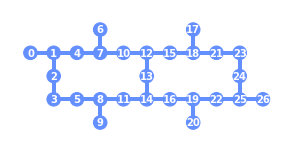

In [18]:
# Backend

# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

qiskit.visualization.plot_gate_map(FAKE_BACKEND)

In [19]:
# Initial State Part

initial_state_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)

initial_state_circuit.x(0)
initial_state_circuit.barrier()

# Litmus Parts

l1_circuit = get_litmus_circuit(QUBITS_COUNT, "L1")
l2_circuit = get_litmus_circuit(QUBITS_COUNT, "L2")

# Measurement Part

measurement_circuit = qiskit.QuantumCircuit(QUBITS_COUNT, QUBITS_COUNT)
measurement_circuit.measure(qubits, qubits)

# Circuit Parts

CIRCUIT_PARTS = [
    initial_state_circuit,
    l1_circuit,
    l2_circuit,
    measurement_circuit
]

In [20]:
circuits_to_compare = get_circuits_to_compare(
    circuit_parts=CIRCUIT_PARTS,
    backend=backend,
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,  
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

results = run_circuits_to_compare(
    circuits_to_compare=circuits_to_compare, 
    backend=backend, 
    shots_count=SHOTS_COUNT
)

plot_results_to_compare(results)

Combined {'1010101011': 1000}
Blocks   {'1010101011': 1000}
Chain    {'1010101011': 1000}
Right    {'1010101011': 1000}
Left     {'1010101011': 1000}


In [21]:
assert check_delta(results), "Check Delta"

## AE and QFT Types Comparison

In [22]:
QUBITS_COUNT = 6

# LAYOUT_METHOD = 'sabre'
LAYOUT_METHOD = None
# ROUTING_METHOD = 'sabre'
ROUTING_METHOD = None

# ‘trivial’, ‘dense’, ‘noise_adaptive’, ‘sabre’
# ‘basic’, ‘lookahead’, ‘stochastic’, ‘sabre’, ‘none’

SHOTS_COUNT = 1000
SEED_TRANSPILER = 1234
OPTIMIZATION_LEVEL = 3

qubits = list(range(QUBITS_COUNT))


# Backend

# FAKE_BACKEND = FakeBackend5QV2()
# FAKE_BACKEND = FakeLimaV2()
# FAKE_BACKEND = FakeGuadalupeV2()
# FAKE_BACKEND = FakeBoeblingenV2()
FAKE_BACKEND = FakeMontrealV2()

backend = AerSimulator.from_backend(FAKE_BACKEND)

backend.options.noise_model = None

# qiskit.visualization.plot_gate_map(FAKE_BACKEND)

### Sinusoids

In [23]:
# sinusoids_data = get_sinusoids(QUBITS_COUNT, frequencies=[1])

# sinusoids_data = get_sinusoids(QUBITS_COUNT, 1)

sinusoids_data = get_sinusoids(QUBITS_COUNT, 
                               frequencies=[1, 3],
                               amplitudes=[10, 5])

# Plot Sinusoids

# plt.title("Amplitude Encoded Signal")
# plt.xlabel("Time")
# plt.ylabel("Amplitude")

# plt.plot(sinusoids_data);

### Circuit Parts

In [24]:
# AE Part

amplitude_embedding = qiskit.circuit.library.StatePreparation(sinusoids_data)

ae_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)
ae_circuit.append(amplitude_embedding, qargs=qubits)
ae_circuit.barrier()

# QFT Part

qft = qiskit.circuit.library.QFT(num_qubits=QUBITS_COUNT)

qft_circuit = qiskit.QuantumCircuit(QUBITS_COUNT)
qft_circuit.append(qft, qargs=qubits)
qft_circuit.barrier()

# Measurement Part

measurement_circuit = qiskit.QuantumCircuit(QUBITS_COUNT, QUBITS_COUNT)
measurement_circuit.measure(qubits, qubits)

# Circuit Parts

CIRCUIT_PARTS = [
    ae_circuit,
    qft_circuit,
    measurement_circuit
]

In [25]:
circuits_to_compare = get_circuits_to_compare(
    circuit_parts=CIRCUIT_PARTS,
    backend=backend,
    layout_method=LAYOUT_METHOD,
    routing_method=ROUTING_METHOD,  
    seed_transpiler=SEED_TRANSPILER,
    optimization_level=OPTIMIZATION_LEVEL
)

results = run_circuits_to_compare(
    circuits_to_compare=circuits_to_compare, 
    backend=backend, 
    shots_count=SHOTS_COUNT
)

In [29]:
# plot_results_to_compare(results, print_counts=False, display_plots=True)

In [27]:
assert check_delta(results), "Check Delta"